In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
%pip install mlflow dagshub

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import mlflow
     

# # set the tracking server

# mlflow.set_tracking_uri("https://dagshub.com/gulamkibria775/ML_Project.mlflow")
     

import dagshub
dagshub.init(repo_owner='gulamkibria775', repo_name='ML_Project', mlflow=True)


Accessing as gulamkibria775

Initialized MLflow to track repo "gulamkibria775/ML_Project"

Repository gulamkibria775/ML_Project initialized!

In [4]:
from sklearn import set_config

set_config(transform_output="pandas")

In [5]:
# load the data

df = pd.read_csv('swiggy.csv')

In [6]:
df=data_clean_utils.perform_data_cleaning(df)

In [7]:
df.shape

(45502, 19)

In [8]:

columns_to_drop =  [
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45589,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [9]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

<Axes: >

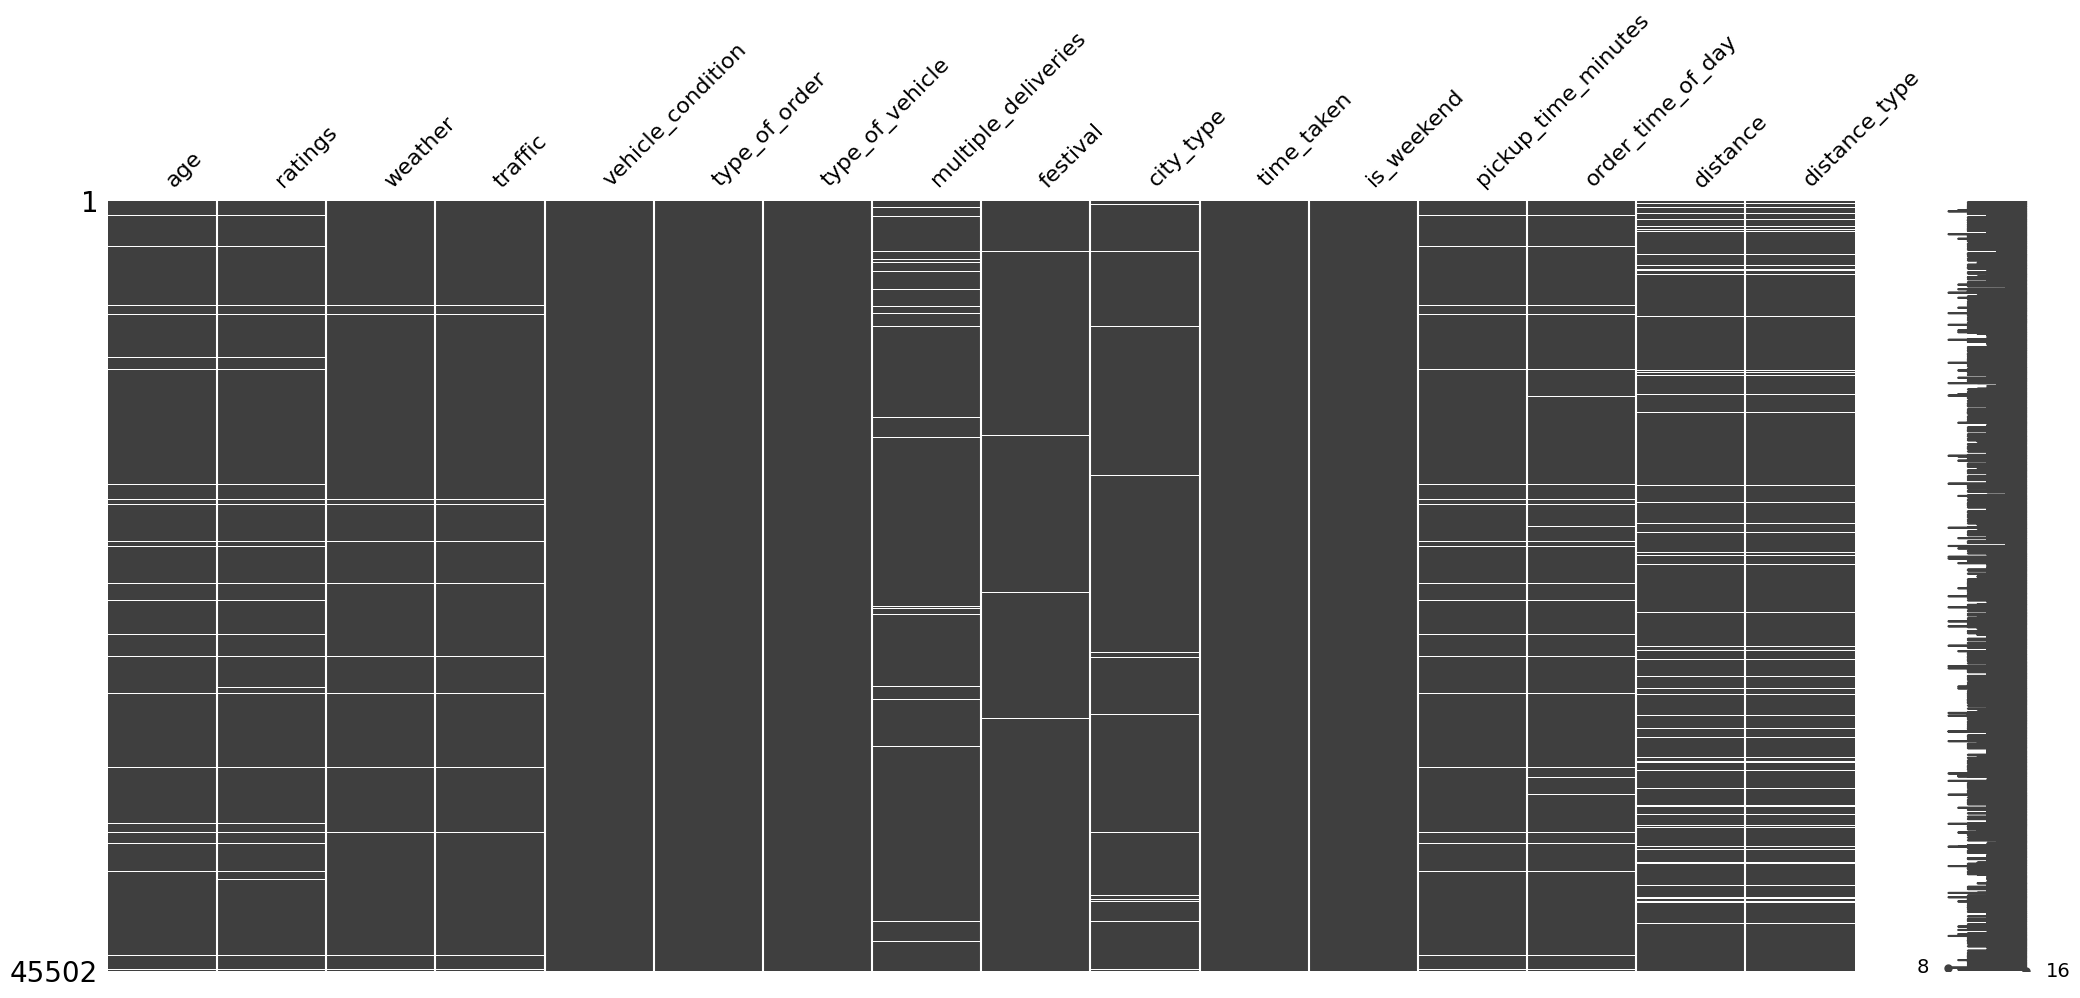

In [10]:
import missingno as msno

msno.matrix(df)

In [11]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [12]:
import mlflow
     

# # set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/gulamkibria775/ML_Project.mlflow")
     

In [13]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Keep Vs Drop Missing Values")

<Experiment: artifact_location='mlflow-artifacts:/82600a1cd0834384933675827dd01335', creation_time=1754655855666, experiment_id='0', last_update_time=1754655855666, lifecycle_stage='active', name='Exp 1 - Keep Vs Drop Missing Values', tags={}>

In [14]:
temp_df = df.copy().dropna()

In [15]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

In [16]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [18]:
# missing data in training data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [19]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [20]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [21]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [22]:
# transform the data

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_trans

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8720,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25245,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34118,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
26036,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37194,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20275,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7601,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13632,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [23]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train_trans,y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# get the predictions
y_pred_train = rf.predict(X_train_trans)
y_pred_test = rf.predict(X_test_trans)

In [26]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [27]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [28]:
from sklearn.metrics import r2_score
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [29]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,X_train_trans,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80766883, 0.80974394, 0.80991245, 0.80948276, 0.81196153])

<Axes: >

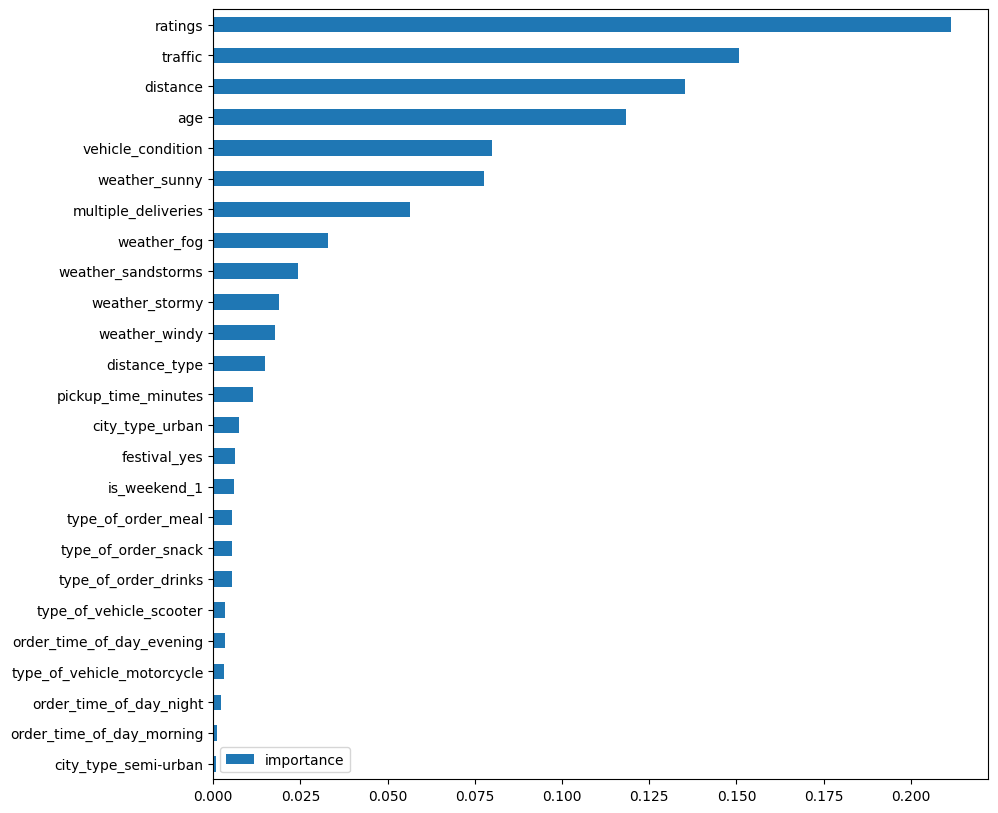

In [30]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=X_train_trans.columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [31]:
# log experiment
from sklearn.metrics import mean_absolute_error
with mlflow.start_run(run_name="Drop Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Drop Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Drop Missing Values at: https://dagshub.com/gulamkibria775/ML_Project.mlflow/#/experiments/0/runs/20e9749abfb5480ca002642071d3fa6e
🧪 View experiment at: https://dagshub.com/gulamkibria775/ML_Project.mlflow/#/experiments/0


In [32]:
from sklearn.feature_selection import RFECV

In [33]:
rfecv = RFECV(
    estimator=rf,
    step=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

In [34]:
# select features

rfecv.fit(X_train_trans,y_train_pt.values.ravel())

Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 15 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.
Fitting estimator with 5 features.


,estimator,RandomForestRegressor()
,step,10
,min_features_to_select,1
,cv,5
,scoring,'r2'
,verbose,2
,n_jobs,-1
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None


In [36]:
rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_motorcycle',
       'type_of_vehicle_scooter', 'festival_yes', 'city_type_semi-urban',
       'city_type_urban', 'is_weekend_1', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night', 'traffic',
       'distance_type', 'vehicle_condition', 'multiple_deliveries'],
      dtype=object)

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(X_train_trans),y_train_pt.values.ravel())

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
# get the predictions
y_pred_train = rf.predict(rfecv.transform(X_train_trans))
y_pred_test = rf.predict(rfecv.transform(X_test_trans))

In [39]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [40]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.09 minutes


In [41]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [42]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,rfecv.transform(X_train_trans),y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80863054, 0.81058078, 0.81017288, 0.80803528, 0.81206567])

In [43]:
scores.mean()

np.float64(0.8098970295445241)

In [44]:
rf.feature_importances_

array([0.11835878, 0.2109249 , 0.01144259, 0.13448626, 0.03324312,
       0.02274151, 0.01969662, 0.07876719, 0.01823784, 0.00540111,
       0.00550616, 0.00529925, 0.00307244, 0.00349655, 0.00642289,
       0.00082166, 0.00730144, 0.00585693, 0.00324757, 0.00113052,
       0.0022028 , 0.15231042, 0.01608354, 0.08050922, 0.0534387 ])

<Axes: >

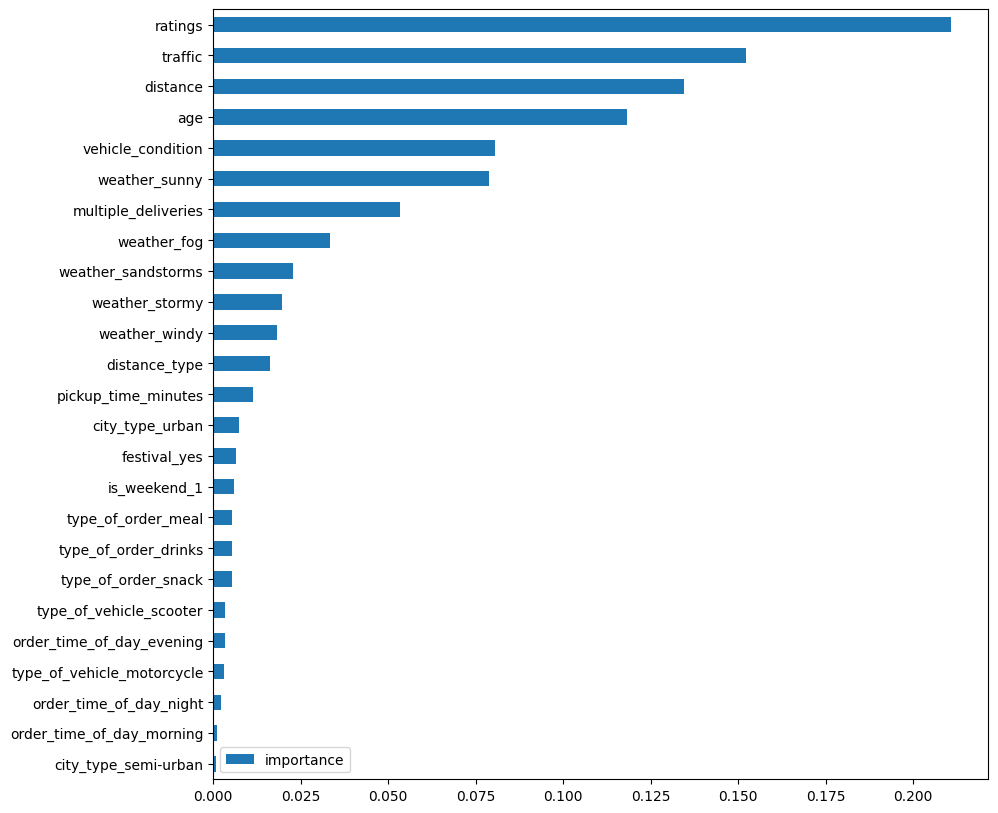

In [45]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=rfecv.transform(X_train_trans).columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [46]:
temp_df = df.copy()

In [47]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

In [48]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [49]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (36401, 15)
The shape of test data is (9101, 15)


In [50]:
# missing values in train data

X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [51]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [52]:

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)

np.float64(17.0)

In [53]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'is_weekend',
 'order_time_of_day']

In [54]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [55]:
simple_imputer.fit_transform(X_train)

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
11047,1.0,no,metropolitian,windy,snack,electric_scooter,0,evening,26.0,4.7,jam,2,10.0,9.177684,medium
15692,1.0,no,metropolitian,windy,drinks,motorcycle,0,afternoon,21.0,4.9,medium,2,5.0,6.081536,medium
14499,1.0,no,metropolitian,stormy,meal,scooter,1,missing,NaN,NaN,low,2,NaN,1.554563,short
29258,1.0,no,metropolitian,windy,buffet,motorcycle,0,evening,32.0,4.7,medium,0,15.0,20.852271,very_long
22554,0.0,no,urban,sandstorms,meal,scooter,0,night,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.0,no,metropolitian,sandstorms,meal,scooter,0,evening,29.0,4.7,jam,2,5.0,12.464367,long
44821,0.0,no,urban,cloudy,buffet,motorcycle,0,morning,36.0,4.8,low,0,10.0,1.520432,short
38234,0.0,no,metropolitian,fog,buffet,scooter,0,evening,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,windy,meal,scooter,1,afternoon,25.0,4.9,medium,2,5.0,7.760938,medium


In [56]:
simple_imputer.fit_transform(X_train).isna().sum()

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
is_weekend                0
order_time_of_day         0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [57]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

In [58]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [59]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [60]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

,transformers,"[('scale', ...), ('nominal_encode', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [61]:
preprocessor.fit_transform(X_train)

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,city_type_nan,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11047,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15692,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14499,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29258,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22554,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44821,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38234,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [62]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


age                    1470
ratings                1510
pickup_time_minutes    1298
distance               2931
multiple_deliveries     795
dtype: int64

In [63]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [64]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [65]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt.values.ravel())

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode_imputer', ...), ('missing_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [66]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [67]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [68]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.30 minutes


In [69]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.80


In [70]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_pipe,X_train,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated 

array([0.7777986 , 0.78280601, 0.78231181, 0.7765916 , 0.7805493 ])

In [71]:
# mean score

scores.mean()

np.float64(0.7800114634065091)

In [72]:
# log experiment

with mlflow.start_run(run_name="Impute Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Impute Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Impute Missing Values at: https://dagshub.com/gulamkibria775/ML_Project.mlflow/#/experiments/0/runs/1682b5a8748a499e82b4c72dd2d66d81
🧪 View experiment at: https://dagshub.com/gulamkibria775/ML_Project.mlflow/#/experiments/0
